# The attractor states of the functional brain connectome

## Analysis Notebook 

Most of the analysis is based the module connattractor, which contains the core Hopfield network model as well as the method of generating the Hopfield embeddings. The Hopfield class provides the base for all calculations, including the update rule, the energy function and the relaxation of input patterns to attractor states. The HopfieldEmbeddings class is built on top, with its core function to create the projection plane and the boundaries between the attractor states, based off of real or simulated data. The HopfieldEmbeddings class also contains a very potent plotting function, that allows us to easily generate various styles of plots for the hopfield projection. 

As discussed in the manuscript, all analyses are based on a fcHNN initialized with the same connectome, to highlight the generalizabilty. An overview of the coarse optimization over the two hyperparameters noise and temperature is given in the beginning of this notebook. 


#### Imports

In [1]:
import sys
sys.path.append('..') # to make sure the connattractor module is available, even if not installed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
from sklearn.preprocessing import StandardScaler
import nilearn
from tqdm import tqdm
from connattractor import network, analysis

#### Load mean connectome for study 1
This is the same as study 1 from (Spisak et al., 2020, Nat. Comm.)

In [2]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'

mtx = pd.read_csv(connfile).iloc[:, 1:]
mtx

,CER6_p,CER7ab,R_CERCR2_p,CER9_v,CER6_a,L_CERCR2_a,CER9_d,CER9_m,CER7b_m,L_CERCR2_p,...,LVISnet_vp,MVISnet_p,MVISnet_av,LVISnet_p,PVISnet_dm,PVISnet_vm,MVISnet_ad,VVISnet_l,LVISnet_DP,VVISnet_m
0,1.000000,0.023502,0.136701,0.008193,0.074264,0.021580,0.170827,0.028969,0.015883,0.130981,...,-0.002248,-0.008683,0.000152,0.035482,0.007705,-0.029055,0.009439,-0.001390,0.009582,0.007318
1,0.023502,1.000000,0.008167,0.024126,0.046648,0.050263,0.010915,0.070042,0.085829,-0.018248,...,0.033791,0.004000,0.011493,0.007582,-0.026080,0.008013,-0.009007,0.009144,0.001391,0.012831
2,0.136701,0.008167,1.000000,0.005056,0.062669,0.028488,0.041643,0.045169,0.112164,0.157129,...,-0.003300,0.016258,-0.011801,-0.001794,-0.000603,0.012350,-0.002757,-0.004949,-0.004858,-0.000633
3,0.008193,0.024126,0.005056,1.000000,-0.020494,-0.008721,-0.004522,0.203525,-0.003757,0.019182,...,0.021645,0.000472,-0.003774,0.003395,-0.032710,-0.015305,0.007360,0.004044,-0.011696,-0.001293
4,0.074264,0.046648,0.062669,-0.020494,1.000000,0.080293,0.024584,0.002491,-0.021720,0.042291,...,-0.020753,0.005295,-0.012844,-0.014833,0.009989,0.024167,-0.005186,-0.016061,0.010920,-0.007650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.029055,0.008013,0.012350,-0.015305,0.024167,-0.007512,0.045950,0.010056,-0.006412,-0.000421,...,0.011186,0.215436,-0.011083,-0.003814,0.163692,1.000000,0.013773,0.049101,-0.028493,0.115196
118,0.009439,-0.009007,-0.002757,0.007360,-0.005186,-0.023476,-0.004195,-0.029927,-0.023948,-0.023841,...,-0.012657,0.258308,0.091981,0.007686,-0.001867,0.013773,1.000000,-0.013407,0.017465,0.032366
119,-0.001390,0.009144,-0.004949,0.004044,-0.016061,0.004057,0.002311,-0.022643,0.001888,-0.007811,...,0.139682,-0.014010,0.077810,0.079338,0.055300,0.049101,-0.013407,1.000000,0.081084,0.162297
120,0.009582,0.001391,-0.004858,-0.011696,0.010920,0.002928,-0.001322,0.004114,-0.006720,-0.008002,...,0.066451,0.001324,-0.001214,0.115287,0.089609,-0.028493,0.017465,0.081084,1.000000,0.000165


## Hopfield embeddings and projection - coarse optimization
In this section, we generate the Hopfield embeddings based on the loaded connectome (study 1), we set the beta to 0.04 to produce 4 states (see the notebook `sweep_beta.ipynb` for more details). For the stochastic walk to generate simulated data, we do a coarse optimization to the noise paramater, so that the distribution of the simulated data in the 2D projection compares to the real data.

#### First we scrub the data:

In [3]:
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
root_dir = '../data_in/ex_timeseries/'
for f in glob(root_dir + 'bochum-???.tsv'):
    path, filename = os.path.split(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv(path + '/FD_' + os.path.splitext(filename)[0] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

perc. scrubbed: 0.515


#### Next, we simulate data with fcHNNs, with various noise leveles, and construct fcHNN projections.

In [4]:
simresults_all = {}
hopfield_embeddings_all = {}

for noise in [0.33, 0.35, 0.37, 0.39]:
    simresults_all[noise] = analysis.simulate_activations(mtx.values, noise_coef=noise, 
                                                          num_iter=100000, beta=0.04, random_state=2023)
    hopfield_embeddings_all[noise] = analysis.create_embeddings(simresults_all[noise], 
                                                                attractor_sample=1000,random_state=2023)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.48it/s]


#### Here we save the results.
Given the generalizability of fcHNN analysis across datasets (see later in this notebook), these can be used as "template fcHNN models".

See our [quickstart](https://pni-lab.github.io/connattractor/quickstart) guide for more info.

In [5]:
for noise in [0.33, 0.35, 0.37, 0.39]:
    simresults_all[noise].save('../data_out/default_statespace_' + str(noise) + '.pkl')
    hopfield_embeddings_all[noise].save('../data_out/default_hopfield_embedding_' + str(noise) + '.pkl')

#### Let's plot the real data and the fcHNN simulations, both on the fCHNN projection.

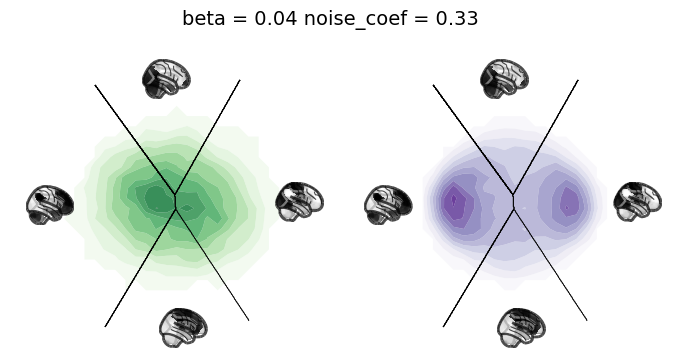

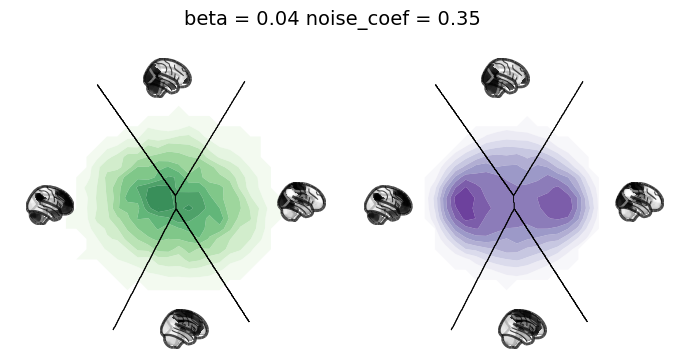

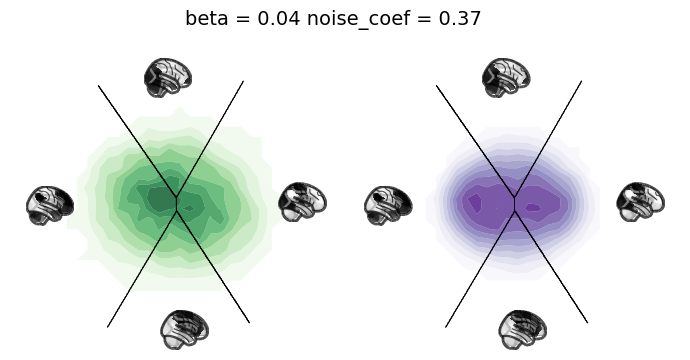

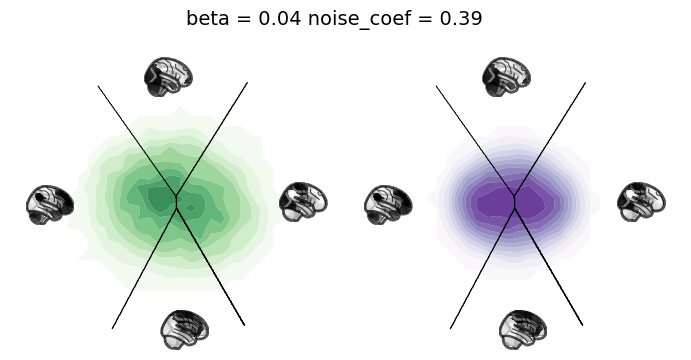

In [6]:
for i in simresults_all.keys():

    fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': 'polar'}, figsize=(8, 4))
    fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
    hopfield_embeddings_all[i].plot(all_ts, plot_type='contourf', ax=ax[0],
                             density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Greens',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[0].set_yticks([])
    ax[0].grid(False)

    hopfield_embeddings_all[i].plot(simresults_all[i].states, plot_type='contourf', ax=ax[1],
                             density_bins=30, density_sigma=0, levels=12, alpha=0.8, cmap='Purples',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[1].set_yticks([])
    ax[1].grid(False)
    plt.savefig('../data_out/fig/emp_vs_generated_beta_' + str(i) + '.pdf')
    plt.show()


#### Zoom in on the peaks

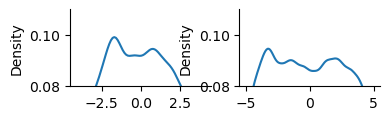

In [7]:
noise = 0.37
density_bins=25

fig, ax = plt.subplots(ncols=2, figsize=(4, 1), sharey=False, sharex=False)

states = StandardScaler().fit_transform(np.array(all_ts).T).T
embeddings = hopfield_embeddings_all[noise].embedding_model.transform(states)
sns.kdeplot(embeddings[np.abs(embeddings[:,1])<=1.5, 0].flatten(), bw_adjust=0.6, ax=ax[0])
ax[0].set_xlim(-4.5,4.5)
ax[0].set_ylim(0.08,0.11)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

states = StandardScaler().fit_transform(np.array(simresults_all[noise].states).T).T
embeddings = hopfield_embeddings_all[noise].embedding_model.transform(states)
sns.kdeplot(embeddings[np.abs(embeddings[:,1])<=1.5, 0].flatten(), bw_adjust=0.8, ax=ax[1])
ax[1].set_xlim(-5.5,5.5)
ax[1].set_ylim(0.08,0.11)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)


### fcHNN projection

We set the noise level to 0.37, so that the simulated data roughly follows the bimodal distribution of the real timeseries data in the fcHNN projection plane. Note that this is intentionally only a very coarse optimization across the noise parameter.

We visualize the simulated samples in the projection plane, each sample color coded to its corresponding attractor state. The positions of the attractor states are their **true** positions in the projection plane, and not just a visual guide for the state sample bins.

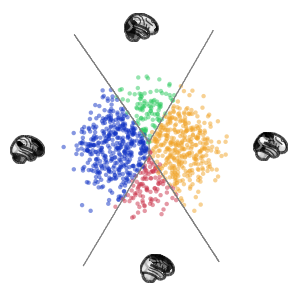

In [8]:
noise = 0.37
colors = np.array(['#cb334a', '#0f31c4', '#f1a429', '#2ecb61'])
fig, ax = plt.subplots(figsize=(3.5,3.5), subplot_kw={'projection': 'polar'})
ax=hopfield_embeddings_all[noise].plot(
                        hopfield_embeddings_all[noise].state_sample,
                        s=10, ax=ax, linewidth=0,
                        c=colors[hopfield_embeddings_all[noise].attractor_sample.astype(int)], 
                        alpha=0.5, regimes_fill_kwargs=dict(alpha=0),
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary')
)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/embedding_example.pdf')

### Energies 
In the following cell, we show the energy level of each of the state samples in the projection plane. It is to be expected that the energy decreases with the distance to the center of the plane, as the attractor states are energy minimal equilibrium states of the system and are located at the far ends of the plane.

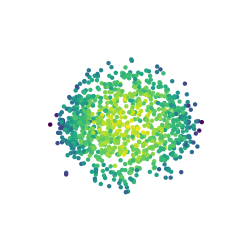

In [9]:
noise = 0.33
colors = np.array(['#2ecb61', '#0f31c4','#f1a429', '#cb334a'])

energy = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in hopfield_embeddings_all[noise].state_sample])

fig, ax = plt.subplots(figsize=(3,3), subplot_kw={'projection': 'polar'})
ax=hopfield_embeddings_all[noise].plot(
                        hopfield_embeddings_all[noise].state_sample,
                        s=10, ax=ax,
                        c=energy,
                        cmap='viridis',
                        alpha=1, regimes_fill_kwargs=dict(alpha=0),
                        regimes_contour_kwargs=dict(alpha=0),
                        attractor_kwargs=dict(alpha=0),
                        attractor_plot_type='scatter'#, attractor_kwargs=dict(cmap='binary')
)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/embedding_energy.pdf')

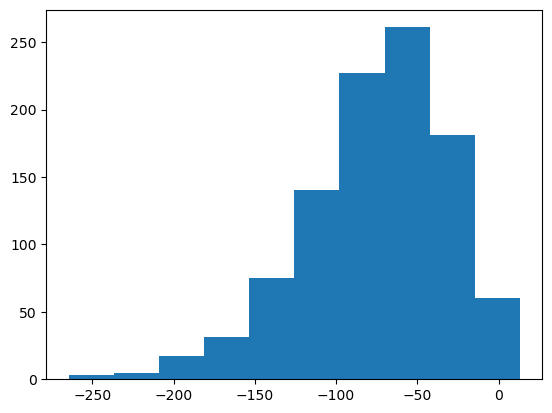

In [10]:
plt.hist(energy)
plt.show()

### Streamplots 

We add a function to create streamplots, that visualizes the changes in trajectory of group level activations in the 2D projection plane. This method allows us to highlight changes in dynamic behaviour in the projection plane to compare conditions, pain vs no-pain for example.

In detail, we calculate the direction in the projection plane between each successive TR and calculate a two-dimensional binned mean for the x,y position across the direction. We then smooth the resulting 2-d histograms to eliminate noise. We repeat the same for the second condition and visualize the difference in direction between the two conditions, using matplotlib's great 'streamplot' function.

In [11]:
from scipy.ndimage import gaussian_filter

def add_relative_streamplot(projection1, projection2, sigma=5,
                             stream_bins=30, ax=None, max_r=None, **kwargs):
    from scipy.stats import binned_statistic_2d
    
    if ax is None:
        ax = plt.gca()
    if max_r is None:
        max_r = np.max(np.abs(np.vstack((projection1, projection2))))
    
    default_kwargs = dict(linewidth=5, density=1.2)
    default_kwargs.update(kwargs)
    stream_linewidth = default_kwargs.pop('linewidth')
    
    directions1 = projection1[1:, :] - projection1[:-1, :]

    dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
                                                    np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)])
    dir_x_1[np.isnan(dir_x_1)] = 0
    dir_y_1[np.isnan(dir_y_1)] = 0
    dir_x_1 = gaussian_filter(dir_x_1, sigma=sigma, mode='wrap')
    dir_y_1 = gaussian_filter(dir_y_1, sigma=sigma, mode='wrap')

    directions2 = projection2[1:, :] - projection2[:-1, :]

    dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r*1.1, max_r*1.1, stream_bins),
                                                    np.linspace(-max_r*1.1, max_r*1.1, stream_bins)])
    dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
                                                    statistic=np.mean,
                                                    bins=[np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins),
                                                          np.linspace(-max_r * 1.1, max_r * 1.1,
                                                                      stream_bins)])
    dir_x_2[np.isnan(dir_x_2)] = 0
    dir_y_2[np.isnan(dir_y_2)] = 0
    dir_x_2 = gaussian_filter(dir_x_2, sigma=sigma, mode='wrap')
    dir_y_2 = gaussian_filter(dir_y_2, sigma=sigma, mode='wrap')

    x, y = np.meshgrid((x_edges[:-1]+x_edges[1:])/2,
                       (y_edges[:-1]+y_edges[1:])/2)

    dir_x = dir_x_2-dir_x_1
    dir_y = dir_y_2-dir_y_1

    speed = np.sqrt(dir_x ** 2 + dir_y ** 2)
    print('speed range:', np.min(speed), np.max(speed))

    ax_cart = ax.figure.add_axes(ax.get_position(), polar=False, frameon=False, zorder=-1)
    ax_cart.streamplot(x, y, dir_x, dir_y,
                       linewidth= stream_linewidth * speed / speed[~ np.isnan(speed)].max(),
                       **default_kwargs)
    rlim=ax.get_ylim()[1]
    print(rlim)
    ax_cart.set_ylim((-rlim, rlim)) # 
    ax_cart.set_xlim((-rlim, rlim))
    
    return ax_cart, dir_x, dir_y

## Visualizing the attractor states' "gravitational pull"
Here we use the above function to justify that both the real and fcHNN-simulated "brain trajectories" are different from permuted null models. As expected, the trajectories are focused outwards from the center and towards the attractor states, as the "gravitational pull" of the attractors aims to bring the system into equilibrium. 

speed range: 0.008913952442156486 0.9870682480333255
5.0
speed range: 0.08794707971543332 2.0624222433098733
5.0


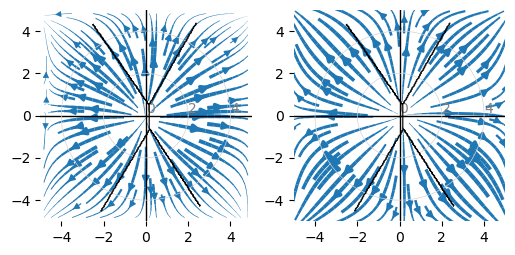

In [12]:
noise=0.37

random = np.random.default_rng(2023)
perm  = random.permutation(np.arange(all_ts.shape[0]))

embedded_sim = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states)
embedded_sim_perm = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states[perm, :])

embedded_emp = hopfield_embeddings_all[noise].embedding_model.transform(all_ts)
embedded_emp_perm = hopfield_embeddings_all[noise].embedding_model.transform(all_ts[perm, :])


fig, ax = plt.subplots(ncols = 2, subplot_kw={'projection': 'polar'}, figsize=(6, 3))



hopfield_embeddings_all[noise].plot(simresults_all[noise].states, plot_type='contourf', ax=ax[0],
                    density_bins=50, density_sigma=0, levels=12, alpha=0, cmap='Purples',
                    attractor_plot_type='scatter',# attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax[0].set_rmax(5)
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_sim_perm, embedded_sim, ax=ax[0],
                                  stream_bins = 30, density=1, linewidth=3, cmap='Purples')
#ax[0].set_yticks([])
#ax[0].grid(False)
#ax_cart.set_yticks([])
#ax_cart.grid(False)



hopfield_embeddings_all[noise].plot(all_ts, plot_type='contourf', ax=ax[1],
                    density_bins=50, density_sigma=0.5, levels=12, alpha=0, cmap='Greens',
                    attractor_plot_type='scatter',# attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax[1].set_rmax(5)
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_emp_perm, embedded_emp, ax=ax[1], max_r=5,
                                 stream_bins = 30, density=1, linewidth=3, cmap='Greens')

#ax[1].set_yticks([])
#ax[1].grid(False)
#ax_cart.set_yticks([])
#ax_cart.grid(False)


## Fractional occupancy

In this segment we investigate the fractional occupancy of the attractor states, i.e. the fraction of activations that converge to each of the attractors. For the timeseries data, we input each of the TRs into the Hopfield network and relax it to a stable pattern, for the simulated data we can extract the frequency of the states from the embedding object. 

We compare the empirical fractional occupancy to uniform frequencies (25% for each state) with a $\tilde{\chi}^2$ test.

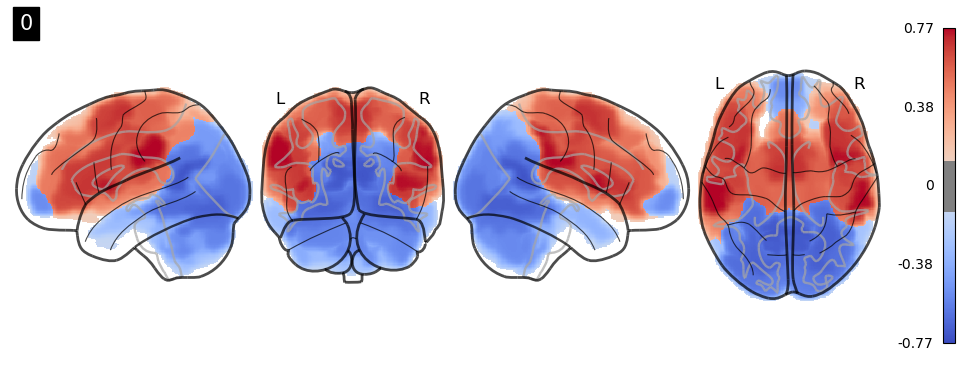

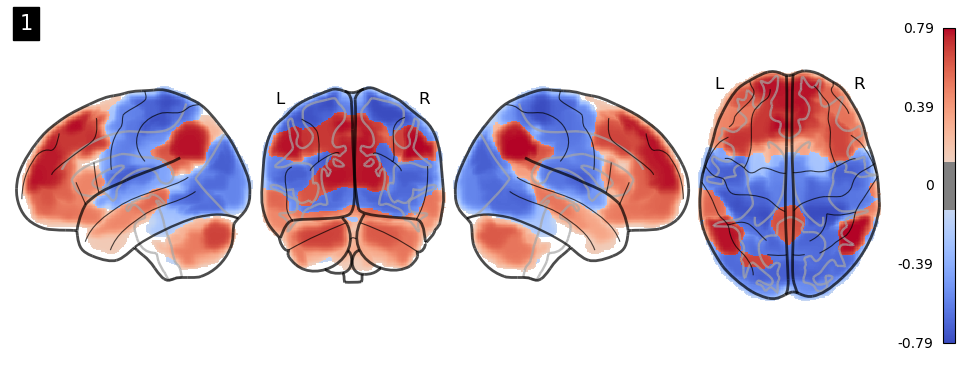

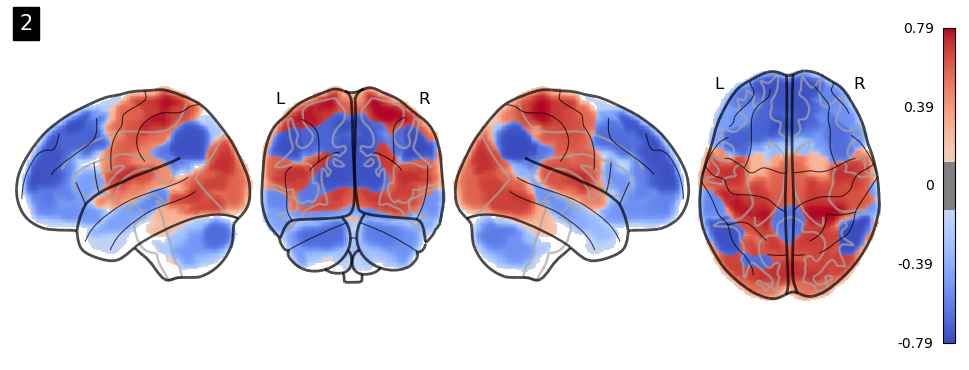

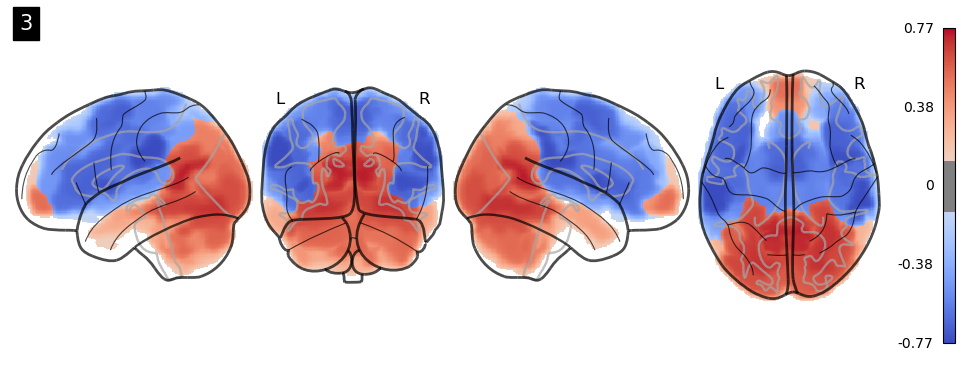

In [13]:
noise=0.37
for k, v in hopfield_embeddings_all[noise].attractors.items():
    ax = network.State(v).plot(title=str(k))
    plt.show()

Next, we obtain the attractor state label for each time-frame from the real data.

In [ ]:
# time spent in state
noise= 0.37

emp_attractor_states = []
for s in tqdm(range(all_ts.shape[0])):
    emp_attractor_states.append(hopfield_embeddings_all[noise].hopnet.update(all_ts[s, :])[0])

 52%|███████████████████████████████████████████████████████████████████████████████▉                                                                           | 3713/7200 [07:16<38:20,  1.52it/s]

In [ ]:
attractor_order  = [2, 0, 1, 3]

attractors = { tuple(v): k for k, v in hopfield_embeddings_all[noise].attractors.items() }
attractor_labels = []

for a in emp_attractor_states: 
    attractor_labels.append(attractors[tuple(np.round(a, 6))])

label, counts = np.unique(attractor_labels, return_counts=True)

plt.pie(counts[attractor_order], labels = label[attractor_order])
# add a white circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig('../data_out/fig/fractional_occ_emp.pdf')
print(counts / np.sum(counts) * 100)

# statistics
from scipy.stats import chisquare
chisquare(counts)



Now we calculate fractional occupancies of the attractor states in the simulated data (stochastic relaxation).

In [ ]:

label_emp, counts_emp = np.unique(attractor_labels[:1000], return_counts=True) # sample empirical data

sim_attractor_states = hopfield_embeddings_all[noise].attractor_sample
label, counts = np.unique(sim_attractor_states, return_counts=True)

plt.pie(counts[attractor_order], labels = label[attractor_order])
# add a white circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig('../data_out/fig/fractional_occ_sim.pdf')
print(counts / np.sum(counts) * 100)
chisquare(counts, counts_emp) # does this differ from empirical data?


See the notebook `null_models.ipynb` for p-values for the fractional occupancy similarity, based on phase randomized timeseries.

## Reconstructing step size
The simulation might be more fine-grained than the real data, depending on the hyperparameters. While this issue is out of the scope of the present analysis, here we perform a preliminary investiagtion of how many fcHNN-steps are needed to travel the same distance on the projection as the real data travels within 1 TR.

In [ ]:
noise = 0.37

# load data
from glob import glob
import os

fig, ax = plt.subplots(ncols=6, figsize=(8, 1.5), sharey=True, sharex=True)

random = np.random.default_rng(2023)

all_ts = []

norms_emp = []
norms_emp_perm = []
for f in glob('../data_in/ex_timeseries/bochum-???.tsv'):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(ts)
    
    perm  = random.permutation(np.arange(ts.shape[0]))
    embedded_perm = hopfield_embeddings_all[noise].embedding_model.transform(ts[perm, :])
    
    # no scrubbing to preserve continuity
    deltas = embedded[1:, :] - embedded[:-1, :]
    norms_emp.append(np.sqrt(deltas[:,0]**2 + deltas[:,1]**2))
    
    deltas_perm = embedded_perm[1:, :] - embedded_perm[:-1, :]
    norms_emp_perm.append(np.sqrt(deltas_perm[:,0]**2 + deltas_perm[:,1]**2))

from matplotlib import cm
maxstep=20
for i, step in enumerate([1, 10, 20, 30, 40, 500]):
    # calculate norms
    activations = StandardScaler().fit_transform(simresults_all[noise].states.T).T
    embedded = hopfield_embeddings_all[noise].embedding_model.transform(simresults_all[noise].states)
    deltas = embedded[step:, :] - embedded[:-step, :]
    norms_sim = np.sqrt(deltas[:,0]**2 + deltas[:,1]**2)
    
    ax[i].hist(np.array(norms_emp).flatten(), bins=12, histtype='bar', range=(0,12),
         alpha=0.5, density=True, color='green')
    ax[i].hist(np.array(norms_emp_perm).flatten(), bins=12, histtype='bar', range=(0,12),
         alpha=0.5, density=True, color='gray', linestyle=':')
    ax[i].set(title='n_step = ' + str(step))
    
    ax[i].hist(norms_sim, bins=12, histtype='step', range=(0,12),
             density=True, color="purple")
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
plt.gca().set_xlim((0, 8))
plt.tight_layout()
plt.savefig('../data_out/fig/step_convergence.pdf')


It looks like min. 30-40 fcHNN steps correspond a real TR in study 1, but this needs to be investigated further.

## Reconstruction of the connectome

The simulated data created with the stochastic walk of the CHNN, is capable of reconstructing the connectome from which the network weights are initialized. We simulate activations with the established parameters and calculate the partial correlation of the simulated timeseries.

In [ ]:
from nilearn import plotting

def plot_matrix(mat, **kwargs):
    
    mat[range(mat.shape[0]), range(mat.shape[0])] = 0
    
    atlas_labels = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t')
    
    labels = atlas_labels.labels.values
    modules = atlas_labels.modules.values
    
    fig = plt.gcf()
    fig.set_size_inches(3, 3)
    ax = fig.add_axes([0,0,1,1], frameon=False)
    
    plotting.plot_matrix(mat, **kwargs, zorder=0, axes=ax)
    
    prev=""
    idx=0
    
    
    for i in range(len(labels)):
        if modules[i]!=prev:
            print(modules[i])
            ax.plot([-5, len(labels) + 0.5], [i-0.5, i-0.5], linewidth=1, color='gray', zorder=100)
            ax.plot([i - 0.5, i - 0.5], [-5, len(labels) + 0.5], linewidth=1, color='gray', zorder=100)

            idx=idx+1
            prev=modules[i]

In [ ]:
from nilearn.connectome import ConnectivityMeasure

plot_matrix(mtx.values, vmin=-0.1, vmax=0.1, cmap="coolwarm", tri='full')
plt.savefig('../data_out/fig/connectome_empirical.pdf')

In [ ]:
noise=0.37
sim = analysis.simulate_activations(mtx.values, noise_coef=noise, num_iter=7200, beta=0.04)
correlation_measure = ConnectivityMeasure(kind="partial correlation")
reconstructed_matrix = correlation_measure.fit_transform([sim.states])[0]
plot_matrix(reconstructed_matrix, vmin=-0.1, vmax=0.1, cmap="coolwarm", tri='full')
plt.savefig('../data_out/fig/connectome_reconstructed.pdf')

## Hopfiled-PCA vs. PCA on the actual resting state data

To investigate the validity of our model in the most simplistic scenario, we compare the explained variance of a linear regressor of the first two principal components of the empirical timeseries with the first two PCs of the simulated data (stochastic walk samples). We compare the explanatory power in-sample and out-of-sample for both empirical and simulated data

#### Load data again, just to be sure

In [ ]:
# PCA explained var
noise = 0.37

import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
for f in glob('../data_in/ex_timeseries/bochum-???.tsv'):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv('../data_in/ex_timeseries/FD_' + filename.split('/')[-1] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

from sklearn.decomposition import PCA

pca_raw_study1 = PCA().fit(all_ts)
pca_hopfield_study1 = PCA().fit(simresults_all[noise].states)

### In-sample explanatory power

In [ ]:
#point estimates
from sklearn.linear_model import LinearRegression
n_comp = 2
reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_raw_pca = np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2
reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_hop_pca = np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2

# bootstrap
n_boot=100
r2_raw_pca_boot = []
r2_hop_pca_boot = []
for i in tqdm(range(n_boot)):
    
    bootstrap_idx = random.choice(all_ts.shape[0], size=all_ts.shape[0], replace=True)
    
    reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_raw_pca_boot.append(np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

    reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_hop_pca_boot.append(np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

r2_raw_pca, np.quantile(r2_raw_pca_boot, (0.05, 0.95)), r2_hop_pca, np.quantile(r2_hop_pca_boot, (0.05, 0.95))

#### Plot it

In [ ]:
means = [r2_raw_pca, r2_hop_pca]
labels = ['raw', 'Hopfield']
conf = np.array([np.quantile(r2_raw_pca_boot, (0.005, 0.995)),
              np.quantile(r2_hop_pca_boot, (0.005, 0.995))])

yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T                  
             
fig, ax = plt.subplots(figsize=(3, 3))
plt.bar(labels, means, align='center', 
        yerr=yerr)
plt.savefig('../data_out/fig/pca_in-sample.pdf')

### Out-of-sample explanatory power

In [ ]:
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
for f in glob('../data_in/ex_timeseries/essen-*.tsv'):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv('../data_in/ex_timeseries/FD_' + filename.split('/')[-1] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

n_comp=2

random = np.random.default_rng(42)

#point estimates
reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_raw_pca = np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2
reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts.T)
r2_hop_pca = np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts.T.flatten()
                                       )[0,1]**2

# bootstrap
n_boot=100
r2_raw_pca_boot = []
r2_hop_pca_boot = []
for i in tqdm(range(n_boot)):
    
    bootstrap_idx = random.choice(all_ts.shape[0], size=all_ts.shape[0], replace=True)
    
    reg = LinearRegression().fit(X = pca_raw_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_raw_pca_boot.append(np.corrcoef(reg.predict(pca_raw_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

    reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=all_ts[bootstrap_idx, :].T)
    r2_hop_pca_boot.append(np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        all_ts[bootstrap_idx, :].T.flatten()
                                       )[0,1]**2)

r2_raw_pca, np.quantile(r2_raw_pca_boot, (0.05, 0.95)), r2_hop_pca, np.quantile(r2_hop_pca_boot, (0.05, 0.95))

In [ ]:
means = [r2_raw_pca, r2_hop_pca]
labels = ['raw', 'Hopfield']
conf = np.array([np.quantile(r2_raw_pca_boot, (0.005, 0.995)),
              np.quantile(r2_hop_pca_boot, (0.005, 0.995))])

yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T                  
             
fig, ax = plt.subplots(figsize=(3, 3))
plt.bar(labels, means, align='center', 
        yerr=yerr)
plt.savefig('../data_out/fig/pca_out-of-sample.pdf')

### Now let's see how much does the 2-d fcHNN projection explain in the simulated states

In [ ]:
reg = LinearRegression().fit(X = pca_hopfield_study1.components_[:n_comp, :].T, y=simresults_all[0.37].states.T)
r2_hop_pca = np.corrcoef(reg.predict(pca_hopfield_study1.components_[:n_comp, :].T).flatten(),
                                        simresults_all[0.37].states.T.flatten()
                                       )[0,1]**2
r2_hop_pca

# Hopfiled embedding of task-based timeseries

The fcHNN projection, combined with the aforementioned streamplots, provides a unique framework in which we can visualize, analyze and predict how activations dynamically change between two conditions.

We highlight these properties study 4 (Woo et al., 2015) which investigated the self-regulation of pain. We  divide the timeseeries data into pain task and rest phases, taking into account the 6s delay to adjust for the hemodynamic response function with the corresponding nilearn function, as shown below:

In [ ]:
from nilearn.glm.first_level import compute_regressor
signal, _labels = compute_regressor(
    exp_condition = np.array((0, 12, 1)).reshape(3, 1),
    hrf_model = 'spm',
    frame_times = np.arange(0,40, step=2))

plt.plot(np.arange(0,40, step=2), [1]*6 + [0]*14)
plt.plot(np.arange(0,40, step=2), signal)
plt.grid(True)

### Comparison in projection plane

First we load and scrub the data, then group the activations into "rest" and "pain", and transform all single TR activations (density plot) as well was the participant-level mean activations to the CHNN projection plane (triangles). 

In [ ]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts.txt', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-01_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    for i in events.index: 
        
        onset = int(np.round(events.loc[i, "onset"]/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]
        #else:
        #    # anticipation and scoring
        #    current_block = ts[(onset+int(np.round((0)/_TR_))):(onset+int(np.round(6/_TR_))), :]
        #    rest = np.vstack((rest, current_block))                
   
# remove all nans (scrubbing)

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)
                                                              

In [ ]:
# save for later:
rest_noreg = rest.copy()
task_noreg = task.copy()
sub_rest_noreg = sub_rest.copy()
sub_task_noreg = sub_task.copy()

#### Plot the two conditions, and their difference, on the fcHNN projection.

In [ ]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_rest.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_pain.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


for i in range(len(sub_means_rest)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    


ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_pain-rest.pdf')

### Spatial difference in projection plane

The spatial difference between rest and pain is visualized with a radial plot, showing the participant-level trajectory on the projection plane from rest to pain, denoted with circles, as well as the group level trajectory (arrow). 

In [ ]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_rest = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
emb_sub_means_task = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
diffs = emb_sub_means_task - emb_sub_means_rest
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

fig, ax = plt.subplots(figsize=(2, 2))

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'), ax=ax)
plt.savefig('../data_out/fig/pain_circplot.pdf')

### Significance testing of spatial difference and energy difference between conditions

Additionally, we test the significance of the spatial difference of the participant-level mean activation in the projection plane with the L2 norm, as well as the energy difference between the two conditions, both with a permutation test, randomly swapping the conditions. 

In [ ]:
from numpy.linalg import norm
random = np.random.default_rng(42)
noise = 0.37
num_perm = 1000


sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

task_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
rest_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
diffs = task_embedded - rest_embedded
true_diffs_norm = np.array([norm(d) for d in diffs])
true_diff_mean = np.mean(true_diffs_norm)

energy_rest = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_rest])
energy_task = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_task])
true_energy_diff = energy_rest - energy_task
true_energy_diff_mean = np.mean(true_energy_diff)

n = len(diffs)
diffs = []
energy_diffs = []

for p in range(num_perm):
    
    
    # swap conditions randomly (i.e. sign flip)
    
    perm_i = random.choice([1,-1], n)
    diffs.append(np.mean(true_diffs_norm * perm_i))
    energy_diffs.append(np.mean(true_energy_diff * perm_i))


plt.figure(figsize=(1,1))
plt.hist(diffs, color='gray')
plt.axvline(true_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_task_vs_rest.pdf')
plt.show()

plt.figure(figsize=(1,1))
plt.hist(energy_diffs, color='gray')
plt.axvline(true_energy_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_task_vs_rest_energy.pdf')
plt.show()


print('p(projection) =', (diffs>true_diff_mean).sum()/num_perm, '\t',
      'p(energy) =', (energy_diffs>true_energy_diff_mean).sum()/num_perm)
    

### Streamplot of difference in conditions

To further highlight the difference between the task and rest conditions, we generate streamplots that visualize the dynamic trajectory of group-level activations. We calculate the direction in the projection plane between each successive TR and calculate a 2-dimensional binned mean for the x,y position across the direction. We repeat the same for the second condition and visualize the difference in direction between the two conditions, visualized as streamplots. 

In [ ]:
embedded_rest_emp = hopfield_embeddings_all[noise].embedding_model.transform(rest_noreg)
embedded_pain_emp = hopfield_embeddings_all[noise].embedding_model.transform(task_noreg)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task_noreg, plot_type='contourf', ax=ax,
                    density_bins=10, density_sigma=0, levels=3, alpha=0.5, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax.set_rmax(3)
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_rest_emp, embedded_pain_emp, ax=ax, max_r=3,
                                  stream_bins = 100, sigma=10, density=0.8, linewidth=6, color='darkred')

dirs_pain_vs_rest_empirical = np.vstack((dir_x, dir_y))

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_pain_vs_rest.pdf')


#### Appearently, a "ghost attractor" emerges in brain dynamics during pain.

Let's see if the fcHNN can reproduce it!

### Streamplot of simulated data, introducing weak pain signal

For the simulated data, we introduce a weak signal according to a meta-analytic pain activation map Zunhammer et al., 2021 to the stochastic walk, aiming to simulate the shift from rest to pain also in the simulated data. We compare the simulated difference to the actual difference through a permutation test where the null-distribution is constructed by randomly swapping the conditions (pain vs. rest) on a per participant basis.

#### First we define a function for permutation testing

In [ ]:
# we create a null distribution by swapping act. vs. rest data randomly, per participant

from joblib import Parallel, delayed
from scipy.stats import binned_statistic_2d

def permtest(embedded_1, embedded_2, sub_1, sub_2, dir_sim_x, dir_sim_y, true_corr,
             max_r=4, stream_bins=30, sigma=5, n_perm=1000):

    def workhorse(seed):
        rng = np.random.default_rng(seed)
        all_subs = np.unique(sub_1) ## all_subs
        
        projection1 = []
        projection2 = []
        for s in all_subs:
            if(rng.choice([-1,1])<0): # do not swap conditions
                projection1.append(embedded_1[sub_1==s, :])
                projection2.append(embedded_2[sub_2==s, :])
            else: # do swap!!
                projection2.append(embedded_1[sub_1==s, :])
                projection1.append(embedded_2[sub_2==s, :])
                
        projection1=np.vstack(projection1)
        projection2=np.vstack(projection2)

        bins = np.linspace(-max_r, max_r, stream_bins)

        directions1 = projection1[1:, :] - projection1[:-1, :]

        dir_x_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 0],
                                                        statistic=np.mean,
                                                        bins=[bins,bins])

        dir_y_1, x_edges, y_edges, _ = binned_statistic_2d(projection1[:-1, 1], projection1[:-1, 0], directions1[:, 1],
                                                        statistic=np.mean,
                                                        bins=[bins,bins])

        dir_x_1[np.isnan(dir_x_1)] = 0
        dir_y_1[np.isnan(dir_y_1)] = 0
        dir_x_1 = gaussian_filter(dir_x_1, sigma=sigma, mode='wrap')
        dir_y_1 = gaussian_filter(dir_y_1, sigma=sigma, mode='wrap')

        directions2 = projection2[1:, :] - projection2[:-1, :]

        dir_x_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 0],
                                                        statistic=np.mean,
                                                        bins=[bins,bins])
        dir_y_2, x_edges, y_edges, _ = binned_statistic_2d(projection2[:-1, 1], projection2[:-1, 0], directions2[:, 1],
                                                        statistic=np.mean,
                                                        bins=[bins,bins])

        dir_x_2[np.isnan(dir_x_2)] = 0
        dir_y_2[np.isnan(dir_y_2)] = 0
        dir_x_2 = gaussian_filter(dir_x_2, sigma=sigma, mode='wrap')
        dir_y_2 = gaussian_filter(dir_y_2, sigma=sigma, mode='wrap')

        dir_x = dir_x_2-dir_x_1
        dir_y = dir_y_2-dir_y_1  

        return pearsonr(np.vstack((dir_sim_x, dir_sim_y)).flatten(), np.vstack((dir_x, dir_y)).flatten())[0]
       
    # set n_jobs=-1 to speed up
    corrs = np.array(Parallel(n_jobs=1)(delayed(workhorse)(seed) for seed in np.arange(n_perm)))
    
    fwer_threshold = np.quantile(corrs[~np.isnan(corrs)], 0.95) 
    p = np.sum(corrs>true_corr)/len(corrs)
    return p, fwer_threshold


#### Next, let's look at the trajectory differences, as predicted by the fcHNN model.

As we don't know how much signal is needed in the fcHNN model to possibly reproduce the "ghost attractor" behavior, we perform a coarse-grained optimization, with 5 different signal weights (SNR values).

In [ ]:
from mlxtend.evaluate import permutation_test
from scipy.stats import spearmanr, pearsonr

pain_map = network.State('../data_in/maps/placebo_metaanalysis_full_pain_g_random.nii.gz')

simresults_rest = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                      num_iter=10000, beta=0.04,
                                                      random_state=42)

fig, ax = plt.subplots(ncols = 5, subplot_kw={'projection': 'polar'}, figsize=(20, 4))

for i, SNR in enumerate([0.001, 0.003, 0.005, 0.007, 0.009]):

    signal = np.array(pain_map)

    simresults_pain = analysis.simulate_activations(mtx.values, noise_coef=0.37,
                                                          num_iter=10000, beta=0.04,
                                                          signal = signal * SNR,
                                                          random_state=42)

    embedded_rest = hopfield_embeddings_all[noise].embedding_model.transform(simresults_rest.states)
    embedded_pain = hopfield_embeddings_all[noise].embedding_model.transform(simresults_pain.states)

    np.max(np.abs(np.vstack((embedded_rest, embedded_pain))))

    hopfield_embeddings_all[noise].plot(simresults_pain.states, plot_type='contourf', ax=ax[i],
                        density_bins=20, density_sigma=0, levels=12, alpha=0.5, cmap='Reds',
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    ax[i].set_rmax(3)
    ax_cart, dir_x, dir_y  = add_relative_streamplot(embedded_rest, embedded_pain, ax=ax[i], max_r=3,
                                      stream_bins = 100, sigma=10, density=1.3, linewidth=6, color='darkred')
    dirs_pain_vs_rest_simulated = np.vstack((dir_x, dir_y))
    
    true_corr = pearsonr(dirs_pain_vs_rest_empirical.flatten(), dirs_pain_vs_rest_simulated.flatten())[0]
    print('corr:', true_corr)
    
    # permute blocks in the empirical data (per particcipant)
    p_value, fwer_threshold = permtest(embedded_rest_emp, embedded_pain_emp, sub_rest_noreg, sub_task_noreg, 
                                 dir_x, dir_y, true_corr, stream_bins=100, sigma=10, max_r=3)

    ax[i].set_title('SNR=' + str(np.round(SNR,4)) + ' p=' + str(np.round(p_value, 5)))
    print(p_value)
    #ax[i].set_yticks([])
    #ax[i].grid(False)
    #ax_cart.set_yticks([])
    #ax_cart.grid(False)

We see the "ghost attractor" from SNR>=3, with greatest similarity to the real empirical data with SNR=0.005 (p=0.005 with permutation testing)!

#### Let's have a closer look!

In [ ]:
from mlxtend.evaluate import permutation_test
from scipy.stats import spearmanr, pearsonr

#pain_map = network.State('../data_in/maps/placebo_metaanalysis_full_pain_g_random.nii.gz')

simresults_rest = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                      num_iter=10000, beta=0.04,
                                                      random_state=42)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

SNR=0.005

signal = np.array(pain_map)

simresults_pain = analysis.simulate_activations(mtx.values, noise_coef=0.37,
                                                          num_iter=10000, beta=0.04,
                                                          signal = signal * SNR,
                                                          random_state=42)

embedded_rest = hopfield_embeddings_all[noise].embedding_model.transform(simresults_rest.states)
embedded_pain = hopfield_embeddings_all[noise].embedding_model.transform(simresults_pain.states)

np.max(np.abs(np.vstack((embedded_rest, embedded_pain))))




hopfield_embeddings_all[noise].plot(simresults_pain.states, plot_type='contourf', ax=ax,
                        density_bins=20, density_sigma=0, levels=3, alpha=0.5, cmap='Reds',
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax.set_rmax(3)
ax_cart, dir_x, dir_y  = add_relative_streamplot(embedded_rest, embedded_pain, ax=ax, max_r=3,
                                      stream_bins = 100, sigma=10, density=1.3, linewidth=6, color='darkred')
dirs_pain_vs_rest_simulated = np.vstack((dir_x, dir_y))
    
true_corr = pearsonr(dirs_pain_vs_rest_empirical.flatten(), dirs_pain_vs_rest_simulated.flatten())[0]
print('corr:', true_corr)
    
# permute blocks in the empirical data (per particcipant)
p_value, fwer_threshold = permtest(embedded_rest_emp, embedded_pain_emp, sub_rest_noreg, sub_task_noreg, 
                             dir_x, dir_y, true_corr, stream_bins=100, sigma=10, max_r=3)

ax.set_title('SNR=' + str(np.round(SNR,4)) + ' p=' + str(np.round(p_value, 5)))
print(p_value)
ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_pain_vs_rest_sim.pdf')

## Same but with low pain vs. high pain
(not reported in the main text of the manuscript)

In [ ]:
rest = task[temperatures<43]
task = task[temperatures>=43]
sub_rest = sub_task[temperatures<43]
sub_task = sub_task[temperatures>=43]

In [ ]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='v', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_low.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Reds',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='v', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_high.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(ax=ax,
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )


for i in range(len(sub_means_rest)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    hopfield_embeddings_all[noise].plot(sub_means_rest[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='v', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    hopfield_embeddings_all[noise].plot(sub_means_task[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='v', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_high-low.pdf')

In [ ]:
sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

In [ ]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_rest = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
emb_sub_means_task = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
diffs = emb_sub_means_task - emb_sub_means_rest
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'))

## Can fcHNN capture the effect of pain self-regulation?

We load data from (Woo et al., 2015), to investigate data with pain down- and up-reegulation.


#### First we load the data with up-regulated pain

In [ ]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD_run_07.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts_run_07.tsv', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-07_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    run_start = events.loc[0, 'onset']-18
    
    for i in events.index: 
        
        onset = int(np.round((events.loc[i, "onset"]-run_start)/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]
        #else:
        #    # anticipation and scoring
        #    current_block = ts[(onset+int(np.round((0)/_TR_))):(onset+int(np.round(6/_TR_))), :]
        #    rest = np.vstack((rest, current_block))                
   
# remove all nans (scrubbing)

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)
                                                              

In [ ]:
# save for later:
rest_upreg = rest.copy()
task_upreg = task.copy()
sub_rest_upreg = sub_rest.copy()
sub_task_upreg = sub_task.copy()

#### Plot it in the projection space

In [ ]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_rest_upreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Oranges',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/task_pain_upreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))


for i in range(len(sub_means_rest)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_rest[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='^', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_task[i].reshape(1, -1), plot_type='scatter', ax=ax,
                        marker='^', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_pain-rest_upreg.pdf')

In [ ]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_rest = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_rest)[:, :2]
emb_sub_means_task = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_task)[:, :2]
diffs = emb_sub_means_task - emb_sub_means_rest
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'))

#### Load down-regulation data

In [ ]:
# read task-timeseries

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD_run_03.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts_run_03.tsv', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-03_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    run_start = events.loc[0, 'onset']-18
    
    for i in events.index: 
        
        onset = int(np.round((events.loc[i, "onset"]-run_start)/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]
        #else:
        #    # anticipation and scoring
        #    current_block = ts[(onset+int(np.round((0)/_TR_))):(onset+int(np.round(6/_TR_))), :]
        #    rest = np.vstack((rest, current_block))                
   
# remove all nans (scrubbing)

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)
                                                              

In [ ]:
# save for later:
rest_downreg = rest.copy()
task_downreg = task.copy()
sub_rest_downreg = sub_rest.copy()
sub_task_downreg = sub_task.copy()

#### Plot

In [ ]:
noise = 0.37

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
#fig.suptitle('beta = ' + "0.04" + ' noise_coef = ' + str(i), fontsize=14)
    
hopfield_embeddings_all[noise].plot(rest, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
    
    
    
ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_rest_downreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

hopfield_embeddings_all[noise].plot(task, plot_type='contourf', ax=ax,
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Purples',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_pain_downreg.pdf')
plt.show()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))


for i in range(len(sub_means_rest)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_rest[i], sub_means_task[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_rest, plot_type='scatter', ax=ax,
                        marker='^', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_task, plot_type='scatter', ax=ax,
                        marker='^', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
#plt.savefig('../data_out/fig/task_pain-rest_downreg.pdf')

### Comparing up- vs. down-reegulation

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))

sub_both = list(set(np.unique(sub_task_upreg)) & set(np.unique(sub_task_downreg)))

sub_means_upreg = np.array([np.mean(task_upreg[sub_task_upreg==sub], axis=0) for sub in sub_both])
sub_means_downreg = np.array([np.mean(task_downreg[sub_task_downreg==sub], axis=0) for sub in sub_both])


hopfield_embeddings_all[noise].plot(sub_means_downreg, plot_type='scatter', ax=ax,
                        marker='v', c='blue', s=30, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )
    
hopfield_embeddings_all[noise].plot(sub_means_upreg, plot_type='scatter', ax=ax,
                        marker='v', c='red', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )

for i in range(len(sub_means_upreg)):
    
    hopfield_embeddings_all[noise].plot(np.array([sub_means_upreg[i], sub_means_downreg[i]]), plot_type='line', ax=ax,
                        c='black', linewidth=0.5, alpha=0.3,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0, colors='black')
                       )


ax.set_yticks([])
ax.grid(False)
plt.savefig("../data_out/fig/task_upreg-downreg_pairs.pdf")

In [ ]:
from pingouin import plot_paired, plot_circmean

emb_sub_means_upreg = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_upreg)[:, :2]
emb_sub_means_downreg = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_downreg)[:, :2]
diffs = emb_sub_means_upreg - emb_sub_means_downreg
phi = np.array([np.arctan2(diff[1], diff[0]) for diff in diffs])

plot_circmean(phi, kwargs_markers=dict(marker="o", color='black', fillstyle='full'))
plt.show()


#### Looks promising! But is it significant?

In [ ]:
from numpy.linalg import norm
random = np.random.default_rng(42)
noise = 0.37
num_perm = 1000

sub_both = list(set(np.unique(sub_task_upreg)) & set(np.unique(sub_task_downreg)))

sub_means_upreg = np.array([np.mean(task_upreg[sub_task_upreg==sub], axis=0) for sub in sub_both])
sub_means_downreg = np.array([np.mean(task_downreg[sub_task_downreg==sub], axis=0) for sub in sub_both])

upreg_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_upreg)[:, :2]
downreg_embedded = hopfield_embeddings_all[noise].embedding_model.transform(sub_means_downreg)[:, :2]
diffs = upreg_embedded - downreg_embedded
true_diffs_norm = np.array([norm(d) for d in diffs])
true_diff_mean = np.mean(true_diffs_norm)

energy_downreg = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_downreg])
energy_upreg = np.array([hopfield_embeddings_all[noise].hopnet.energy(s) for s in sub_means_upreg])
true_energy_diff = energy_upreg - energy_downreg
true_energy_diff_mean = np.mean(true_energy_diff)

n = len(diffs)
diffs = []
energy_diffs = []

for p in range(num_perm):
    
    
    # swap conditions randomly (i.e. sign flip)
    
    perm_i = random.choice([1,-1], n)
    diffs.append(np.mean(true_diffs_norm * perm_i))
    energy_diffs.append(np.mean(true_energy_diff * perm_i))
                                                  

plt.figure(figsize=(1,1))
plt.hist(diffs, color='gray')
plt.axvline(true_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_upreg_vs_downreg.pdf')
plt.show()

plt.figure(figsize=(1,1))
plt.hist(energy_diffs, color='gray')
plt.axvline(true_energy_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('../data_out/fig/permtest_upreg_vs_downreg_energy.pdf')
plt.show()


print('p(projection) =', (diffs>true_diff_mean).sum()/num_perm,
      'p(energy) =', (energy_diffs>true_energy_diff_mean).sum()/num_perm)


#### We found significant difference in the location of the two conditions on the projection, but not in their energy.

### No we plot the trajectory differences between up- and down-regulation in the projection-space

In [ ]:
noise=0.37
embedded_downreg = hopfield_embeddings_all[noise].embedding_model.transform(task_downreg)
embedded_upreg = hopfield_embeddings_all[noise].embedding_model.transform(task_upreg)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 3))

hopfield_embeddings_all[noise].plot(task_upreg, plot_type='contourf', ax=ax,
                    density_bins=10, density_sigma=0, levels=3, alpha=0.5, cmap='Reds',
                    attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )
ax.set_rmax(4)
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_upreg, embedded_downreg, ax=ax, max_r=4,
                                  stream_bins = 100, sigma=20, density=1, linewidth=3, color='darkred')

dirs_up_vs_down_empirical = np.vstack((dir_x, dir_y))

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)
#plt.savefig('../data_out/fig/trajectory_up_vs_down.pdf')

#### Somewhat speculatively, down-regulation seems to distracts states from the pain "ghost attractor" towards states of internal context.
In general, there's a shift from external to internal, which makes a lot of sense, given the down-regulation instruuctions.

### Let's see if this is also reproduced by the fcHNN!

We don't change the pain signal SNR and introduce a control signal difference in the Nucleus Accumbens (the region found to mediate up- and down-regulation in Woo et al. 2015). 

In [ ]:
SNR = 0.005 #optimal
SNR_nacc = 0.005 # let's use the same threshold

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 3))

signal = np.array(pain_map) * SNR
signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()] += SNR_nacc

simresults_downreg = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                          num_iter=10000, beta=0.04,
                                                          signal = signal,
                                                          scale=True,
                                                          random_state=42)

signal = np.array(pain_map) * SNR
signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()] -= SNR_nacc


simresults_upreg = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                          num_iter=10000, beta=0.04,
                                                          signal = signal,
                                                          scale=True,
                                                          random_state=42)

embedded_downreg_sim = hopfield_embeddings_all[noise].embedding_model.transform(simresults_downreg.states)
embedded_upreg_sim = hopfield_embeddings_all[noise].embedding_model.transform(simresults_upreg.states)


hopfield_embeddings_all[noise].plot(simresults_upreg.states, plot_type='contourf', ax=ax,
                        density_bins=20, density_sigma=0, levels=3, alpha=0.5, cmap='Reds',
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax.set_rmax(4)
ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_upreg_sim, embedded_downreg_sim, ax=ax, max_r=4,
                                      stream_bins = 100, sigma=20, density=1, linewidth=3, color='darkred')
dirs_up_vs_down_simulated = np.vstack((dir_x, dir_y))
    
true_corr = pearsonr(dirs_up_vs_down_empirical.flatten(), dirs_up_vs_down_simulated.flatten())[0]
print('corr:', true_corr)

# permute blocks in the empirical data (per participant)
p_value, fwer_threshold = permtest(embedded_upreg, embedded_downreg, sub_task_upreg, sub_task_downreg, 
                                 dir_x, dir_y, true_corr, stream_bins=100, sigma=20, max_r=4)

print(p_value)

ax.set_yticks([])
ax.grid(False)
ax_cart.set_yticks([])
ax_cart.set_xticks([])
ax_cart.grid(False)
plt.savefig('../data_out/fig/trajectory_up_vs_down_sim.pdf')

### Seems to be close enough, according to the permutation testing (participant-level random condition swap)!

In [ ]:
SNR = 0.005 #optimal
# let's sweep the threshold a little bit
for SNR_nacc in [0.001, 0.002, 0.0025, 0.003, 0.004, 0.005]:
    print(SNR_nacc)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(3, 3))

    signal = np.array(pain_map) * SNR
    signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()] += SNR_nacc

    simresults_downreg = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                              num_iter=10000, beta=0.04,
                                                              signal = signal,
                                                              scale=True,
                                                              random_state=42)

    signal = np.array(pain_map) * SNR
    signal[np.argwhere(mtx.columns.values == "CAUDNH_NACC").squeeze()] -= SNR_nacc


    simresults_upreg = analysis.simulate_activations(mtx.values, noise_coef=0.37, 
                                                              num_iter=10000, beta=0.04,
                                                              signal = signal,
                                                              scale=True,
                                                              random_state=42)

    embedded_downreg_sim = hopfield_embeddings_all[noise].embedding_model.transform(simresults_downreg.states)
    embedded_upreg_sim = hopfield_embeddings_all[noise].embedding_model.transform(simresults_upreg.states)


    hopfield_embeddings_all[noise].plot(simresults_upreg.states, plot_type='contourf', ax=ax,
                            density_bins=20, density_sigma=0, levels=3, alpha=0.5, cmap='Reds',
                            attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                            regimes_fill_kwargs=dict(alpha=0.0),
                            regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                           )
    ax.set_rmax(4)
    ax_cart, dir_x, dir_y = add_relative_streamplot(embedded_upreg_sim, embedded_downreg_sim, ax=ax, max_r=4,
                                          stream_bins = 100, sigma=20, density=1, linewidth=4, color='darkred')
    dirs_up_vs_down_simulated = np.vstack((dir_x, dir_y))

    true_corr = pearsonr(dirs_up_vs_down_empirical.flatten(), dirs_up_vs_down_simulated.flatten())[0]
    print('corr:', true_corr)

    # permute blocks in the empirical data (per participant)
    p_value, fwer_threshold = permtest(embedded_upreg, embedded_downreg, sub_task_upreg, sub_task_downreg, 
                                     dir_x, dir_y, true_corr, stream_bins=100, sigma=20, max_r=4)

    print(p_value)

    ax.set_yticks([])
    ax.grid(False)
    ax_cart.set_yticks([])
    ax_cart.set_xticks([])
    ax_cart.grid(False)
    plt.show()
#plt.savefig('../data_out/fig/trajectory_up_vs_down_sim.pdf')

Results does not seem to be overly sensitivee to the signal strength in the NAcc.

## Hopfield embeddings vs. various activation maps

We load various meta-analytic activation patterns from NeuroSynth to see how they map on the fcHNN projection plane.

We look at the Neurosynth terms:
- auditory
- autobiographical
- decision
- default mode
- face
- language
- motor
- pain
- reward
- self referential
- semantic memory
- sensory
- sentences
- theory of mind
- visual
- working memory


In [ ]:
# load in Neurosynth maps

fig, axes = plt.subplots(4, 4, figsize=(30, 15))

maps = []
for i, f in enumerate(glob('../data_in/maps/*association-test*')):
    print(f)
    maps.append(network.State(f))
    plotting.plot_glass_brain(f, figure = fig, axes = axes.flat[i], title = f.split('/')[-1].split('_association-test')[0])
plt.show()

#### We load example resting state data (study 1) to plot as a background.

In [ ]:
# load some resting state data
import os
# load resting state data
_fd_thr = 0.15
_perc_scrub_thr = 0.5

# load data
from glob import glob
all_ts = []
for f in glob('../data_in/ex_timeseries/bochum-???.tsv'):
    filename, file_extension = os.path.splitext(f)
    ts = pd.read_csv(f, sep='\t').iloc[:, 1:].values
    ts = StandardScaler().fit_transform(ts)
    fd = pd.read_csv('../data_in/ex_timeseries/FD_' + filename.split('/')[-1] + '.txt', sep=',').values.flatten()
    fd = np.hstack(([0], fd))

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        all_ts.append(ts[fd<_fd_thr])
    else:
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))

all_ts = np.vstack([i for i in all_ts])

#### Plot the maps

In [ ]:
import matplotlib.colors as mcolors
npoise= 0.37

ax = hopfield_embeddings_all[noise].plot(np.array(all_ts), plot_type='contourf',
                             density_bins=30, density_sigma=0, levels=6, alpha=0.8, cmap='Blues',
                        attractor_plot_type='scatter',
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)

colseries = list(mcolors.TABLEAU_COLORS.values()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
colors = np.array(colseries[:len(maps)])

ax = hopfield_embeddings_all[noise].plot(np.tanh(np.array(maps)), alpha=1, s=80, c=colors, plot_type='scatter',
                        ax=ax.figure.add_axes(ax.get_position(), polar=True, frameon=False),
                        attractor_plot_type='glassbrain',
                        attractor_kwargs=dict(cmap='binary'),
                        regimes_fill_kwargs=dict(alpha=0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
#ax.set_axisbelow(True)
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/neurosynth.pdf')

In [ ]:
tmp = list(mcolors.TABLEAU_COLORS.keys()) + ['black', 'white', 'yellow', 'aquamarine', 'lightgray', 'sandybrown']
{f : tmp[i] for i, f in enumerate(glob('../data_in/maps/*association-test*'))}

In [ ]:
ax = hopfield_embeddings_all[noise].plot(np.array(all_ts), plot_type='contourf',
                             density_bins=30, density_sigma=2, levels=6, alpha=0.8, cmap='Blues',
                        attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary_r'),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=0.0)
                       )
ax.set_yticks([])
ax.grid(False)
plt.savefig('../data_out/fig/schematics.pdf')